In [ ]:
!pip install darts

In [203]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Read data and build a `TimeSeries`
`TimeSeries` can be built easily using a few factory methods:

* From an entire Pandas `DataFrame`, using `TimeSeries.from_dataframe()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_dataframe)).
* From a time index and an array of corresponding values, using `TimeSeries.from_times_and_values()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_times_and_values)).
* From a NumPy array of values, using `TimeSeries.from_values()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_values)).
* From a Pandas `Series`, using `TimeSeries.from_series()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_series)).
* From an `xarray.DataArray`, using `TimeSeries.from_xarray()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_xarray)).
* From a CSV file, using `TimeSeries.from_csv()` ([docs](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_csv)).

Below, we get a `TimeSeries` by directly loading the air passengers series from one of the datasets available in Darts:

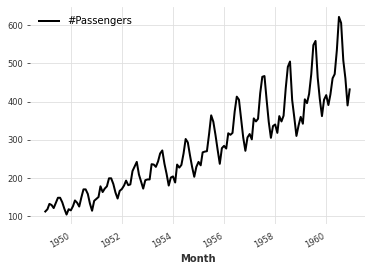

In [204]:
series = AirPassengersDataset().load()
series.plot()

## Creating a training and validation series
For what follows, we will split our `TimeSeries` into a training and a validation series. Note: in general, it is also a good practice to keep a test series aside and never touch it until the end of the process. Here, we just build a training and a validation series for simplicity.

The training series will be a `TimeSeries` containing values until January 1958 (excluded), and the validation series a `TimeSeries` containing the rest:

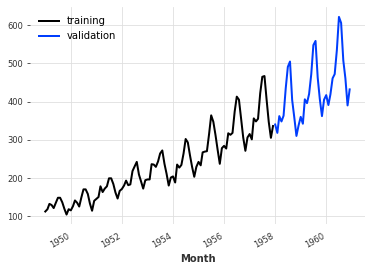

In [220]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

# Training forecasting models and making predictions




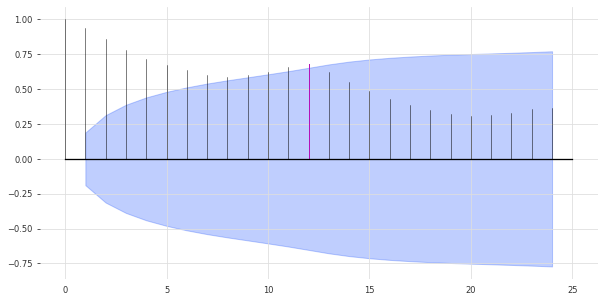

In [206]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of $\alpha = 5\%$. We can also run a statistical check of seasonality for each candidate period `m`:

In [207]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.



## Computing error metrics

This looks already like a fairly decent forecast, and we did not use any non-naive model yet. In fact - any model should be able to beat this. 

So what's the error we will have to beat? We will use the [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) (note that in practice there are often good reasons *not* to use the MAPE - we use it here as it is quite convenient and scale independent). In Darts it is a simple function call:

`darts.metrics` contains many more metrics to compare time series. The metrics will compare only common slices of series when the two series are not aligned, and parallelize computation over a large number of pairs of series - but let's not get ahead of ourselves.

## Quickly try out several models
Darts is built to make it easy to train and validate several models in a unified way. Let's train a few more and compute their respective MAPE on the validation set:

In [208]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.metrics import mape

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%
model (T)BATS obtains MAPE: 5.87%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


Here, we did only built these models with their default parameters. We can probably do better if we fine-tune to our problem. Let's try with the Theta method.

##Trainign and Fitting Theta Model

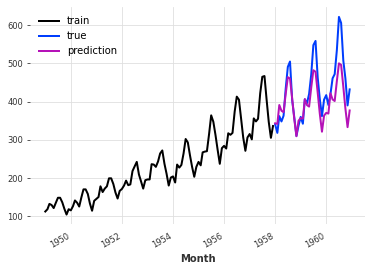

In [209]:
model=Theta()
model.fit(train)
predicted = model.predict(len(val))
train.plot(label="train")
val.plot(label="true")
predicted.plot(label="prediction")

### Searching for hyper-parameters with Optuna Optimization package

The model `Theta` contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has had some success, particularly in the M3-competition.

Though the value of the Theta parameter is often set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. Let's try to find a good value for Theta:

In [210]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances)

In [211]:
def objective(trial):

    # set input_chunk_length, between 5 and 14 days
    thetas = trial.suggest_float("theta", -20,20)
    seasonality_period=trial.suggest_int("seasonality_period", 0,12)

    model = Theta(theta=thetas,seasonality_period=seasonality_period)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    return res

In [212]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, callbacks=[print_callback])

[I 2023-01-01 22:19:23,946] A new study created in memory with name: no-name-3b42b809-4ad2-4354-82ab-4c023c2cb249
[I 2023-01-01 22:19:24,000] Trial 0 finished with value: 11.545058099616549 and parameters: {'theta': -14.898935634732492, 'seasonality_period': 7}. Best is trial 0 with value: 11.545058099616549.
[I 2023-01-01 22:19:24,058] Trial 1 finished with value: 11.548318887291536 and parameters: {'theta': -9.268184874668677, 'seasonality_period': 9}. Best is trial 0 with value: 11.545058099616549.
[I 2023-01-01 22:19:24,096] Trial 2 finished with value: 11.233730744513114 and parameters: {'theta': -2.319987846067729, 'seasonality_period': 2}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,125] Trial 3 finished with value: 12.544448137094355 and parameters: {'theta': 13.353597845470318, 'seasonality_period': 0}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,166] Trial 4 finished with value: 12.594608859236558 and parameters: {'theta':

Current value: 11.545058099616549, Current params: {'theta': -14.898935634732492, 'seasonality_period': 7}
Best value: 11.545058099616549, Best params: {'theta': -14.898935634732492, 'seasonality_period': 7}
Current value: 11.548318887291536, Current params: {'theta': -9.268184874668677, 'seasonality_period': 9}
Best value: 11.545058099616549, Best params: {'theta': -14.898935634732492, 'seasonality_period': 7}
Current value: 11.233730744513114, Current params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 12.544448137094355, Current params: {'theta': 13.353597845470318, 'seasonality_period': 0}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 12.594608859236558, Current params: {'theta': -11.488354945304273, 'seasonality_period': 8}
Best value: 11.233730744513114, Best params: {'theta': -2.31998784

[I 2023-01-01 22:19:24,256] Trial 6 finished with value: 12.670627910062635 and parameters: {'theta': 18.622079376376867, 'seasonality_period': 2}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,306] Trial 7 finished with value: 12.418865811011228 and parameters: {'theta': -6.920720800023862, 'seasonality_period': 11}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,334] Trial 8 finished with value: 12.426792982065844 and parameters: {'theta': 19.48673306017553, 'seasonality_period': 1}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,384] Trial 9 finished with value: 39.013618706798106 and parameters: {'theta': 0.35966079931822037, 'seasonality_period': 11}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,440] Trial 10 finished with value: 14.901582399198244 and parameters: {'theta': 3.9704151128068075, 'seasonality_period': 4}. Best is trial 2 with value: 11.233730744513114.


Current value: 12.670627910062635, Current params: {'theta': 18.622079376376867, 'seasonality_period': 2}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 12.418865811011228, Current params: {'theta': -6.920720800023862, 'seasonality_period': 11}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 12.426792982065844, Current params: {'theta': 19.48673306017553, 'seasonality_period': 1}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 39.013618706798106, Current params: {'theta': 0.35966079931822037, 'seasonality_period': 11}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 14.901582399198244, Current params: {'theta': 3.9704151128068075, 'seasonality_period': 4}
Best value: 11.233730744513114, Best params: {'theta': -2.3199878460

[I 2023-01-01 22:19:24,492] Trial 11 finished with value: 11.950750625023167 and parameters: {'theta': -19.92959624739665, 'seasonality_period': 5}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,553] Trial 12 finished with value: 11.575713192589793 and parameters: {'theta': -19.558880944052802, 'seasonality_period': 7}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,600] Trial 13 finished with value: 13.659817319618739 and parameters: {'theta': 6.418967777218498, 'seasonality_period': 3}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,651] Trial 14 finished with value: 11.867978041015956 and parameters: {'theta': -13.812085205527563, 'seasonality_period': 5}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,698] Trial 15 finished with value: 11.270633430399233 and parameters: {'theta': -3.7571716975110956, 'seasonality_period': 7}. Best is trial 2 with value: 11.233730744513114.


Current value: 11.950750625023167, Current params: {'theta': -19.92959624739665, 'seasonality_period': 5}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.575713192589793, Current params: {'theta': -19.558880944052802, 'seasonality_period': 7}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 13.659817319618739, Current params: {'theta': 6.418967777218498, 'seasonality_period': 3}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.867978041015956, Current params: {'theta': -13.812085205527563, 'seasonality_period': 5}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.270633430399233, Current params: {'theta': -3.7571716975110956, 'seasonality_period': 7}
Best value: 11.233730744513114, Best params: {'theta': -2.3199878460

[I 2023-01-01 22:19:24,755] Trial 16 finished with value: 11.252788166368914 and parameters: {'theta': -3.61424444374766, 'seasonality_period': 6}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,814] Trial 17 finished with value: 11.233789262821281 and parameters: {'theta': -3.382673304591759, 'seasonality_period': 3}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,866] Trial 18 finished with value: 13.03850220205771 and parameters: {'theta': 8.037181213719283, 'seasonality_period': 2}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:24,901] Trial 19 finished with value: 35.85503274742373 and parameters: {'theta': -0.24617176748202674, 'seasonality_period': 0}. Best is trial 2 with value: 11.233730744513114.


Current value: 11.252788166368914, Current params: {'theta': -3.61424444374766, 'seasonality_period': 6}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.233789262821281, Current params: {'theta': -3.382673304591759, 'seasonality_period': 3}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 13.03850220205771, Current params: {'theta': 8.037181213719283, 'seasonality_period': 2}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 35.85503274742373, Current params: {'theta': -0.24617176748202674, 'seasonality_period': 0}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}


[I 2023-01-01 22:19:24,961] Trial 20 finished with value: 17.163104220086137 and parameters: {'theta': 1.906163339225838, 'seasonality_period': 3}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:25,024] Trial 21 finished with value: 11.23862733119041 and parameters: {'theta': -3.643804705876684, 'seasonality_period': 5}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:25,071] Trial 22 finished with value: 11.950801030099711 and parameters: {'theta': -3.5487610230414526, 'seasonality_period': 4}. Best is trial 2 with value: 11.233730744513114.
[I 2023-01-01 22:19:25,120] Trial 23 finished with value: 11.02438308750441 and parameters: {'theta': -2.532463626652995, 'seasonality_period': 3}. Best is trial 23 with value: 11.02438308750441.
[I 2023-01-01 22:19:25,167] Trial 24 finished with value: 12.885896387936532 and parameters: {'theta': 10.434485852052447, 'seasonality_period': 2}. Best is trial 23 with value: 11.02438308750441.


Current value: 17.163104220086137, Current params: {'theta': 1.906163339225838, 'seasonality_period': 3}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.23862733119041, Current params: {'theta': -3.643804705876684, 'seasonality_period': 5}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.950801030099711, Current params: {'theta': -3.5487610230414526, 'seasonality_period': 4}
Best value: 11.233730744513114, Best params: {'theta': -2.319987846067729, 'seasonality_period': 2}
Current value: 11.02438308750441, Current params: {'theta': -2.532463626652995, 'seasonality_period': 3}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995, 'seasonality_period': 3}
Current value: 12.885896387936532, Current params: {'theta': 10.434485852052447, 'seasonality_period': 2}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995,

[I 2023-01-01 22:19:25,205] Trial 25 finished with value: 13.809761474308244 and parameters: {'theta': 3.4970524623336168, 'seasonality_period': 1}. Best is trial 23 with value: 11.02438308750441.
[I 2023-01-01 22:19:25,258] Trial 26 finished with value: 22.88459385196949 and parameters: {'theta': -0.3489565011856657, 'seasonality_period': 3}. Best is trial 23 with value: 11.02438308750441.
[I 2023-01-01 22:19:25,293] Trial 27 finished with value: 11.451721961531002 and parameters: {'theta': -5.793074347552584, 'seasonality_period': 1}. Best is trial 23 with value: 11.02438308750441.
[I 2023-01-01 22:19:25,343] Trial 28 finished with value: 12.654484492236994 and parameters: {'theta': -11.003793069522764, 'seasonality_period': 4}. Best is trial 23 with value: 11.02438308750441.
[I 2023-01-01 22:19:25,391] Trial 29 finished with value: 12.082599964495667 and parameters: {'theta': -13.964956757128238, 'seasonality_period': 3}. Best is trial 23 with value: 11.02438308750441.


Current value: 13.809761474308244, Current params: {'theta': 3.4970524623336168, 'seasonality_period': 1}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995, 'seasonality_period': 3}
Current value: 22.88459385196949, Current params: {'theta': -0.3489565011856657, 'seasonality_period': 3}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995, 'seasonality_period': 3}
Current value: 11.451721961531002, Current params: {'theta': -5.793074347552584, 'seasonality_period': 1}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995, 'seasonality_period': 3}
Current value: 12.654484492236994, Current params: {'theta': -11.003793069522764, 'seasonality_period': 4}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995, 'seasonality_period': 3}
Current value: 12.082599964495667, Current params: {'theta': -13.964956757128238, 'seasonality_period': 3}
Best value: 11.02438308750441, Best params: {'theta': -2.532463626652995

[I 2023-01-01 22:19:25,457] Trial 30 finished with value: 11.01320392139539 and parameters: {'theta': -1.42201743517837, 'seasonality_period': 6}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,504] Trial 31 finished with value: 11.024438155090873 and parameters: {'theta': -1.897972116705271, 'seasonality_period': 6}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,554] Trial 32 finished with value: 11.040945847669493 and parameters: {'theta': -1.3738478918263801, 'seasonality_period': 6}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,604] Trial 33 finished with value: 14.810398302687464 and parameters: {'theta': 3.50358492398769, 'seasonality_period': 8}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,653] Trial 34 finished with value: 11.314231562794578 and parameters: {'theta': -1.1565965272870355, 'seasonality_period': 6}. Best is trial 30 with value: 11.01320392139539.


Current value: 11.01320392139539, Current params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 11.024438155090873, Current params: {'theta': -1.897972116705271, 'seasonality_period': 6}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 11.040945847669493, Current params: {'theta': -1.3738478918263801, 'seasonality_period': 6}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 14.810398302687464, Current params: {'theta': 3.50358492398769, 'seasonality_period': 8}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 11.314231562794578, Current params: {'theta': -1.1565965272870355, 'seasonality_period': 6}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'season

[I 2023-01-01 22:19:25,705] Trial 35 finished with value: 13.940369922894998 and parameters: {'theta': 6.551177310786017, 'seasonality_period': 8}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,753] Trial 36 finished with value: 11.565008423855705 and parameters: {'theta': -9.648614389158755, 'seasonality_period': 9}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,800] Trial 37 finished with value: 11.477342093588039 and parameters: {'theta': -5.935536256696894, 'seasonality_period': 6}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,864] Trial 38 finished with value: 15.715595447231223 and parameters: {'theta': 1.9849860263496053, 'seasonality_period': 6}. Best is trial 30 with value: 11.01320392139539.


Current value: 13.940369922894998, Current params: {'theta': 6.551177310786017, 'seasonality_period': 8}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 11.565008423855705, Current params: {'theta': -9.648614389158755, 'seasonality_period': 9}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 11.477342093588039, Current params: {'theta': -5.935536256696894, 'seasonality_period': 6}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 15.715595447231223, Current params: {'theta': 1.9849860263496053, 'seasonality_period': 6}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}


[I 2023-01-01 22:19:25,913] Trial 39 finished with value: 11.532383564703196 and parameters: {'theta': -8.931928091979934, 'seasonality_period': 9}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:25,978] Trial 40 finished with value: 15.981628601841546 and parameters: {'theta': 1.4540555693445696, 'seasonality_period': 7}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:26,029] Trial 41 finished with value: 11.259163041275484 and parameters: {'theta': -1.9196453399411872, 'seasonality_period': 5}. Best is trial 30 with value: 11.01320392139539.
[I 2023-01-01 22:19:26,082] Trial 42 finished with value: 4.741420071809808 and parameters: {'theta': -6.420450796747532, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.


Current value: 11.532383564703196, Current params: {'theta': -8.931928091979934, 'seasonality_period': 9}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 15.981628601841546, Current params: {'theta': 1.4540555693445696, 'seasonality_period': 7}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 11.259163041275484, Current params: {'theta': -1.9196453399411872, 'seasonality_period': 5}
Best value: 11.01320392139539, Best params: {'theta': -1.42201743517837, 'seasonality_period': 6}
Current value: 4.741420071809808, Current params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:26,134] Trial 43 finished with value: 11.37297320287763 and parameters: {'theta': -6.55343839570061, 'seasonality_period': 9}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,207] Trial 44 finished with value: 5.404405240734396 and parameters: {'theta': -1.8762285316913712, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,261] Trial 45 finished with value: 4.867201953117298 and parameters: {'theta': -7.8616294489745675, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,310] Trial 46 finished with value: 5.025881129616909 and parameters: {'theta': -10.967284931290958, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.


Current value: 11.37297320287763, Current params: {'theta': -6.55343839570061, 'seasonality_period': 9}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.404405240734396, Current params: {'theta': -1.8762285316913712, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 4.867201953117298, Current params: {'theta': -7.8616294489745675, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.025881129616909, Current params: {'theta': -10.967284931290958, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:26,366] Trial 47 finished with value: 5.08649380685434 and parameters: {'theta': -12.916337857535693, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,417] Trial 48 finished with value: 5.169674886518136 and parameters: {'theta': -17.08251082287627, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,476] Trial 49 finished with value: 5.172300201768403 and parameters: {'theta': -17.258202164920426, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,535] Trial 50 finished with value: 12.819267444761806 and parameters: {'theta': -16.430083522170932, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.


Current value: 5.08649380685434, Current params: {'theta': -12.916337857535693, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.169674886518136, Current params: {'theta': -17.08251082287627, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.172300201768403, Current params: {'theta': -17.258202164920426, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.819267444761806, Current params: {'theta': -16.430083522170932, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:26,602] Trial 51 finished with value: 5.182488490654618 and parameters: {'theta': -17.975671885670856, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,650] Trial 52 finished with value: 12.708804318789324 and parameters: {'theta': -12.201188001574028, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,704] Trial 53 finished with value: 5.151903229086721 and parameters: {'theta': -15.981198198371471, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,757] Trial 54 finished with value: 12.238406937997864 and parameters: {'theta': -14.958107114461184, 'seasonality_period': 10}. Best is trial 42 with value: 4.741420071809808.


Current value: 5.182488490654618, Current params: {'theta': -17.975671885670856, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.708804318789324, Current params: {'theta': -12.201188001574028, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.151903229086721, Current params: {'theta': -15.981198198371471, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.238406937997864, Current params: {'theta': -14.958107114461184, 'seasonality_period': 10}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:26,820] Trial 55 finished with value: 12.19148240181082 and parameters: {'theta': -12.589567343001576, 'seasonality_period': 10}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,881] Trial 56 finished with value: 5.143720977350882 and parameters: {'theta': -15.520507200011863, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,930] Trial 57 finished with value: 12.65314191855382 and parameters: {'theta': -10.800402249567647, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:26,982] Trial 58 finished with value: 5.1398044255268225 and parameters: {'theta': -15.309262558735666, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.


Current value: 12.19148240181082, Current params: {'theta': -12.589567343001576, 'seasonality_period': 10}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.143720977350882, Current params: {'theta': -15.520507200011863, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.65314191855382, Current params: {'theta': -10.800402249567647, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.1398044255268225, Current params: {'theta': -15.309262558735666, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:27,041] Trial 59 finished with value: 12.478744392712025 and parameters: {'theta': -7.892599974905487, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,101] Trial 60 finished with value: 12.295522769589311 and parameters: {'theta': -18.533316311157332, 'seasonality_period': 10}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,152] Trial 61 finished with value: 5.117706513982238 and parameters: {'theta': -14.217448205597378, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,204] Trial 62 finished with value: 5.099505560537239 and parameters: {'theta': -13.428643349669683, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.


Current value: 12.478744392712025, Current params: {'theta': -7.892599974905487, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.295522769589311, Current params: {'theta': -18.533316311157332, 'seasonality_period': 10}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.117706513982238, Current params: {'theta': -14.217448205597378, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 5.099505560537239, Current params: {'theta': -13.428643349669683, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:27,260] Trial 63 finished with value: 12.760908763354875 and parameters: {'theta': -13.887194057858892, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,311] Trial 64 finished with value: 4.9856660103294095 and parameters: {'theta': -9.96919385785693, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,369] Trial 65 finished with value: 12.612232925374068 and parameters: {'theta': -9.960002515711798, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,426] Trial 66 finished with value: 4.877944123879123 and parameters: {'theta': -8.0152839101994, 'seasonality_period': 12}. Best is trial 42 with value: 4.741420071809808.


Current value: 12.760908763354875, Current params: {'theta': -13.887194057858892, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 4.9856660103294095, Current params: {'theta': -9.96919385785693, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.612232925374068, Current params: {'theta': -9.960002515711798, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 4.877944123879123, Current params: {'theta': -8.0152839101994, 'seasonality_period': 12}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}


[I 2023-01-01 22:19:27,480] Trial 67 finished with value: 12.460608229383666 and parameters: {'theta': -7.625085542408426, 'seasonality_period': 11}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,529] Trial 68 finished with value: 12.172724369170233 and parameters: {'theta': -11.840109741215134, 'seasonality_period': 10}. Best is trial 42 with value: 4.741420071809808.
[I 2023-01-01 22:19:27,581] Trial 69 finished with value: 4.524549012349037 and parameters: {'theta': -4.608200685996832, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:27,630] Trial 70 finished with value: 12.542582742958874 and parameters: {'theta': -8.794861602864385, 'seasonality_period': 11}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:27,681] Trial 71 finished with value: 4.662944011971602 and parameters: {'theta': -5.761490560406957, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.


Current value: 12.460608229383666, Current params: {'theta': -7.625085542408426, 'seasonality_period': 11}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 12.172724369170233, Current params: {'theta': -11.840109741215134, 'seasonality_period': 10}
Best value: 4.741420071809808, Best params: {'theta': -6.420450796747532, 'seasonality_period': 12}
Current value: 4.524549012349037, Current params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 12.542582742958874, Current params: {'theta': -8.794861602864385, 'seasonality_period': 11}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.662944011971602, Current params: {'theta': -5.761490560406957, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685

[I 2023-01-01 22:19:27,738] Trial 72 finished with value: 4.558406049916202 and parameters: {'theta': -4.9396234214598485, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:27,800] Trial 73 finished with value: 4.549100135244903 and parameters: {'theta': -4.859374513128834, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:27,855] Trial 74 finished with value: 12.27912399883797 and parameters: {'theta': -4.888733569663213, 'seasonality_period': 11}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:27,913] Trial 75 finished with value: 4.546075983030809 and parameters: {'theta': -4.8338543507660106, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.


Current value: 4.558406049916202, Current params: {'theta': -4.9396234214598485, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.549100135244903, Current params: {'theta': -4.859374513128834, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 12.27912399883797, Current params: {'theta': -4.888733569663213, 'seasonality_period': 11}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.546075983030809, Current params: {'theta': -4.8338543507660106, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}


[I 2023-01-01 22:19:27,963] Trial 76 finished with value: 11.784037594007547 and parameters: {'theta': -4.860175502650822, 'seasonality_period': 10}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:28,023] Trial 77 finished with value: 12.283406128889801 and parameters: {'theta': -4.93311737930651, 'seasonality_period': 11}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:28,079] Trial 78 finished with value: 4.802733023708579 and parameters: {'theta': -7.050475849449262, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:28,127] Trial 79 finished with value: 4.774457184826057 and parameters: {'theta': -6.745228274893777, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.


Current value: 11.784037594007547, Current params: {'theta': -4.860175502650822, 'seasonality_period': 10}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 12.283406128889801, Current params: {'theta': -4.93311737930651, 'seasonality_period': 11}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.802733023708579, Current params: {'theta': -7.050475849449262, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.774457184826057, Current params: {'theta': -6.745228274893777, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}


[I 2023-01-01 22:19:28,179] Trial 80 finished with value: 12.355668733476088 and parameters: {'theta': -5.82565547638762, 'seasonality_period': 11}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:28,228] Trial 81 finished with value: 4.787634319660553 and parameters: {'theta': -6.884123702673339, 'seasonality_period': 12}. Best is trial 69 with value: 4.524549012349037.
[I 2023-01-01 22:19:28,281] Trial 82 finished with value: 4.493558367787878 and parameters: {'theta': -2.9957701122896863, 'seasonality_period': 12}. Best is trial 82 with value: 4.493558367787878.
[I 2023-01-01 22:19:28,333] Trial 83 finished with value: 4.506443157252478 and parameters: {'theta': -2.962113810374749, 'seasonality_period': 12}. Best is trial 82 with value: 4.493558367787878.


Current value: 12.355668733476088, Current params: {'theta': -5.82565547638762, 'seasonality_period': 11}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.787634319660553, Current params: {'theta': -6.884123702673339, 'seasonality_period': 12}
Best value: 4.524549012349037, Best params: {'theta': -4.608200685996832, 'seasonality_period': 12}
Current value: 4.493558367787878, Current params: {'theta': -2.9957701122896863, 'seasonality_period': 12}
Best value: 4.493558367787878, Best params: {'theta': -2.9957701122896863, 'seasonality_period': 12}
Current value: 4.506443157252478, Current params: {'theta': -2.962113810374749, 'seasonality_period': 12}
Best value: 4.493558367787878, Best params: {'theta': -2.9957701122896863, 'seasonality_period': 12}


[I 2023-01-01 22:19:28,384] Trial 84 finished with value: 4.405307708097541 and parameters: {'theta': -3.381961585103768, 'seasonality_period': 12}. Best is trial 84 with value: 4.405307708097541.
[I 2023-01-01 22:19:28,444] Trial 85 finished with value: 26.926311673181992 and parameters: {'theta': 0.6213331826627178, 'seasonality_period': 11}. Best is trial 84 with value: 4.405307708097541.
[I 2023-01-01 22:19:28,497] Trial 86 finished with value: 4.513371728161673 and parameters: {'theta': -2.9443265026395853, 'seasonality_period': 12}. Best is trial 84 with value: 4.405307708097541.
[I 2023-01-01 22:19:28,551] Trial 87 finished with value: 12.044863576672899 and parameters: {'theta': -2.9173556791682618, 'seasonality_period': 11}. Best is trial 84 with value: 4.405307708097541.


Current value: 4.405307708097541, Current params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Current value: 26.926311673181992, Current params: {'theta': 0.6213331826627178, 'seasonality_period': 11}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Current value: 4.513371728161673, Current params: {'theta': -2.9443265026395853, 'seasonality_period': 12}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Current value: 12.044863576672899, Current params: {'theta': -2.9173556791682618, 'seasonality_period': 11}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}


[I 2023-01-01 22:19:28,606] Trial 88 finished with value: 4.452928855048263 and parameters: {'theta': -3.986842209157412, 'seasonality_period': 12}. Best is trial 84 with value: 4.405307708097541.
[I 2023-01-01 22:19:28,666] Trial 89 finished with value: 11.733177367352198 and parameters: {'theta': -4.458659599897026, 'seasonality_period': 10}. Best is trial 84 with value: 4.405307708097541.
[I 2023-01-01 22:19:28,726] Trial 90 finished with value: 12.024696065447433 and parameters: {'theta': -2.7584197518299347, 'seasonality_period': 11}. Best is trial 84 with value: 4.405307708097541.
[I 2023-01-01 22:19:28,776] Trial 91 finished with value: 25.98220429854427 and parameters: {'theta': -0.3837193313210401, 'seasonality_period': 12}. Best is trial 84 with value: 4.405307708097541.


Current value: 4.452928855048263, Current params: {'theta': -3.986842209157412, 'seasonality_period': 12}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Current value: 11.733177367352198, Current params: {'theta': -4.458659599897026, 'seasonality_period': 10}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Current value: 12.024696065447433, Current params: {'theta': -2.7584197518299347, 'seasonality_period': 11}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}
Current value: 25.98220429854427, Current params: {'theta': -0.3837193313210401, 'seasonality_period': 12}
Best value: 4.405307708097541, Best params: {'theta': -3.381961585103768, 'seasonality_period': 12}


[I 2023-01-01 22:19:28,835] Trial 92 finished with value: 4.40477865008671 and parameters: {'theta': -3.4023622991512252, 'seasonality_period': 12}. Best is trial 92 with value: 4.40477865008671.
[I 2023-01-01 22:19:28,888] Trial 93 finished with value: 4.481666665210548 and parameters: {'theta': -4.214884237651068, 'seasonality_period': 12}. Best is trial 92 with value: 4.40477865008671.
[I 2023-01-01 22:19:28,950] Trial 94 finished with value: 4.448198748249762 and parameters: {'theta': -3.9516517299138965, 'seasonality_period': 12}. Best is trial 92 with value: 4.40477865008671.
[I 2023-01-01 22:19:29,003] Trial 95 finished with value: 12.091496291131179 and parameters: {'theta': -3.3168657536081114, 'seasonality_period': 11}. Best is trial 92 with value: 4.40477865008671.


Current value: 4.40477865008671, Current params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Current value: 4.481666665210548, Current params: {'theta': -4.214884237651068, 'seasonality_period': 12}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Current value: 4.448198748249762, Current params: {'theta': -3.9516517299138965, 'seasonality_period': 12}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Current value: 12.091496291131179, Current params: {'theta': -3.3168657536081114, 'seasonality_period': 11}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}


[I 2023-01-01 22:19:29,064] Trial 96 finished with value: 4.4448064621906305 and parameters: {'theta': -3.9267943237068232, 'seasonality_period': 12}. Best is trial 92 with value: 4.40477865008671.
[I 2023-01-01 22:19:29,119] Trial 97 finished with value: 9.493478428094798 and parameters: {'theta': -0.9981499890579997, 'seasonality_period': 12}. Best is trial 92 with value: 4.40477865008671.
[I 2023-01-01 22:19:29,168] Trial 98 finished with value: 12.161091442020583 and parameters: {'theta': -3.914817314210916, 'seasonality_period': 11}. Best is trial 92 with value: 4.40477865008671.
[I 2023-01-01 22:19:29,221] Trial 99 finished with value: 24.540209897110355 and parameters: {'theta': 0.4514137429225116, 'seasonality_period': 12}. Best is trial 92 with value: 4.40477865008671.


Current value: 4.4448064621906305, Current params: {'theta': -3.9267943237068232, 'seasonality_period': 12}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Current value: 9.493478428094798, Current params: {'theta': -0.9981499890579997, 'seasonality_period': 12}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Current value: 12.161091442020583, Current params: {'theta': -3.914817314210916, 'seasonality_period': 11}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}
Current value: 24.540209897110355, Current params: {'theta': 0.4514137429225116, 'seasonality_period': 12}
Best value: 4.40477865008671, Best params: {'theta': -3.4023622991512252, 'seasonality_period': 12}


We can observe that the model with `best_theta` is so far the best we have, in terms of MAPE.

So it seems that our best model on validation set is not doing so great anymore when we backtest it (did I hear overfitting :D)

To have a closer look at the errors, we can also use the `backtest()` method to obtain all the raw errors (say, MAPE errors) that would have been obtained by our model:

In [213]:
best_theta=study.best_trial.params["theta"]
best_seasonality_period=study.best_trial.params["seasonality_period"]

print(best_theta)
print(best_seasonality_period)

-3.4023622991512252
12


In [214]:
best_theta_model = Theta(theta=best_theta,seasonality_period = best_seasonality_period)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.4023622991512252.


# Backtesting: simulate historical forecasting
So at this point we have a model that performs well on our validation set, and that's good. But, how can we know the performance we *would have obtained* if we *had been using this model* historically? 

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is (by default) re-trained every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 3 months in the future (compared to prediction time). The result of calling `historical_forecasts()` is (by default) a `TimeSeries` that contains those 3-months ahead forecasts:

100%|██████████| 57/57 [00:01<00:00, 32.99it/s]


MAPE = 4.98%


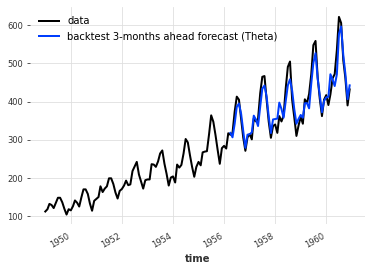

In [215]:

historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

Finally, using `backtest()` we can also get a simpler view of the average error over the historical forecasts:

In [216]:

average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

100%|██████████| 57/57 [00:01<00:00, 33.27it/s]


Average error (MAPE) over all historical forecasts: 3.99


We could also for instance have specified the argument `reduction=np.median` to get the median MAPE instead.

### Looking at residuals
Let's look at the fitted value residuals of our current `Theta` model, i.e. the difference between the 1-step forecasts at every point in time obtained by fitting the model on all previous points, and the actual observed values:

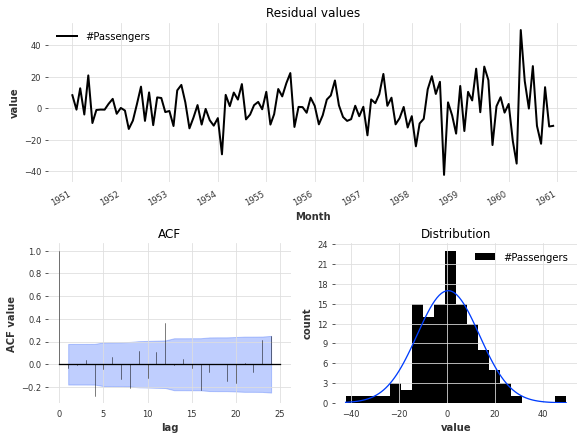

In [217]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

We can see that the distribution is not centered at 0, which means that our Theta model is biased. We can also make out a large ACF value at lag equal to 12, which indicates that the residuals contain information that was not used by the model.

Could we maybe do better with a simple ExponentialSmoothing model?

100%|██████████| 57/57 [00:08<00:00,  6.90it/s]


MAPE = 4.45%


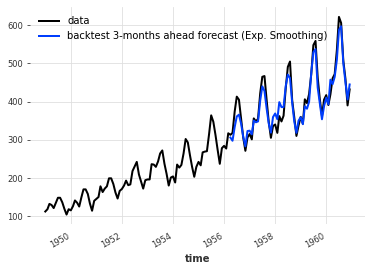

In [218]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

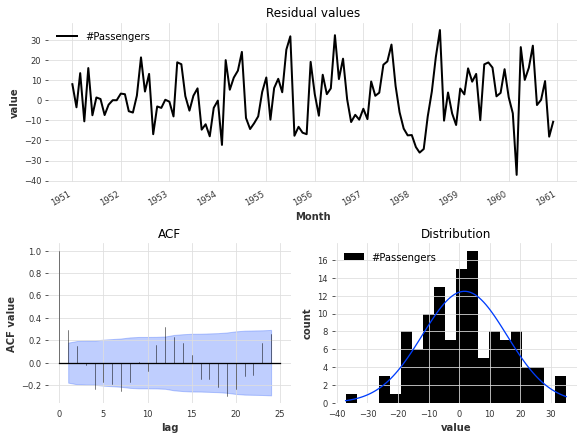

In [219]:
plot_residuals_analysis(model_es.residuals(series))